In [5]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from osgeo import gdal
import threading
import matplotlib.patches as patches
import matplotlib.animation as animation
import imageio
import matplotlib.colors as mcolors
from langchain.tools import Tool
from langchain.agents import initialize_agent
from langchain.chat_models import ChatOpenAI


# **1️⃣ 计算算法执行时间差的工具函数**
def calculate_algorithm_time(func, *args, **kwargs):
    """
    计算从算法开始运行到结束的时间差，并返回执行结果
    """
    start_time = time.time()  # 记录开始时间
    result = func(*args, **kwargs)  # 执行函数
    end_time = time.time()  # 记录结束时间

    time_diff = end_time - start_time  # 计算时间差
    return f"{result} | 运行时间: {time_diff:.6f} 秒"


# **2️⃣ 包装 agent.run 以测量执行时间**
def run_with_time_measurement(agent, command):
    """
    计算 `agent.run(command)` 执行所需的时间
    """
    return calculate_algorithm_time(agent.run, command)
def sliding_window_stats(input_tiff_path, output_folder, window_width=100, window_height=100, step_x=40, step_y=40):
    """
    计算 TIFF 影像的滑动窗口均值和标准差
    :param input_tiff_path: TIFF 文件路径
    :param output_folder: 结果存储文件夹
    :param window_width: 滑动窗口宽度（可变）
    :param window_height: 滑动窗口高度（可变）
    :param step_x: 横向步长
    :param step_y: 纵向步长
    """
    window_width, window_height, step_x, step_y = map(int, [window_width, window_height, step_x, step_y])

    dataset = gdal.Open(input_tiff_path)
    if dataset is None:
        return "❌ 无法打开 TIFF 文件"

    band = dataset.GetRasterBand(1)
    dem_array = band.ReadAsArray().astype(np.float32)
    rows, cols = dem_array.shape

    # 计算滑动窗口数量
    num_windows_y = (rows - window_height) // step_y + 1
    num_windows_x = (cols - window_width) // step_x + 1

    mean_values = np.zeros((num_windows_y, num_windows_x))
    std_values = np.zeros((num_windows_y, num_windows_x))

    # 滑动窗口遍历
    for i, y in enumerate(range(0, rows - window_height + 1, step_y)):  
        for j, x in enumerate(range(0, cols - window_width + 1, step_x)):  
            window_data = dem_array[y:y + window_height, x:x + window_width]
            mean_values[i, j] = np.nanmean(window_data)
            std_values[i, j] = np.nanstd(window_data)

    # 保存均值 & 标准差
    mean_csv_path = os.path.join(output_folder, "sliding_window_mean_values.csv")
    std_csv_path = os.path.join(output_folder, "sliding_window_std_values.csv")

    pd.DataFrame(mean_values).to_csv(mean_csv_path, index=False, header=False)
    pd.DataFrame(std_values).to_csv(std_csv_path, index=False, header=False)

    return f"✅ 滑动窗口计算完成，均值数据已保存到 {mean_csv_path}，标准差已保存到 {std_csv_path}"

# **3️⃣ LangChain 代理初始化**
llm = ChatOpenAI(
    openai_api_key="sk-9d937bf4eeed4cc5b90380549e2f8d08",
    openai_api_base="https://dashscope.aliyuncs.com/compatible-mode/v1",
    model_name="qwen-max",
    max_tokens=200,
    temperature=0,
    streaming=False
)

# **4️⃣ 创建 LangChain 工具对象**
sliding_window_tool_obj = Tool(
    name="Sliding_Window",
    func=lambda x: sliding_window_stats(*x.split(", ")),  
    description="对 TIFF 影像使用滑动窗口计算均值 & 标准差，格式：<TIFF路径>, <输出文件夹>, <窗口宽度>, <窗口高度>, <步长_x>, <步长_y>"
)

compute_exceedance_tool_obj = Tool(
    name="Compute_Exceedance",
    func=lambda x: compute_threshold_exceedance(*x.split(", ")),  
    description="计算超出均值 + 2 * 标准差的像素值之和，格式：<均值 CSV>, <标准差 CSV>, <原始 TIFF>, <输出 CSV>"
)

plot_exceedance_tool_obj = Tool(
    name="Plot_Exceedance",
    func=lambda x: async_plot_threshold_exceedance(*x.split(", ")),
    description="可视化超出阈值的像素值之和，输入格式：<CSV路径>, <输出图片路径>"
)

# **5️⃣ 初始化大模型**
agent = initialize_agent(
    tools=[sliding_window_tool_obj, compute_exceedance_tool_obj, plot_exceedance_tool_obj],
    llm=llm,
    agent="zero-shot-react-description",
    verbose=True,
    allow_dangerous_code=True,
    handle_parsing_errors=True  # 允许解析错误自动重试
)

# **6️⃣ 运行并测量时间**
tiff_path = r"D:\Mars\LunarSlope.tif"
output_folder = r"D:\Mars\process1"
mean_csv_path = os.path.join(output_folder, "sliding_window_mean_values.csv")
std_csv_path = os.path.join(output_folder, "sliding_window_std_values.csv")
exceedance_csv_path = os.path.join(output_folder, "threshold_exceedance.csv")
output_image = os.path.join(output_folder, "threshold_exceedance.png")

window_width = 76
window_height = 57
step_x = 10
step_y = 10

# **测量 滑动窗口计算时间**
response1 = agent.run(f"{tiff_path}, {output_folder}, {window_width}, {window_height}, {step_x}, {step_y}")
print(response1)

# **测量 阈值计算时间**
response2 = run_with_time_measurement(agent, f"{mean_csv_path}, {std_csv_path}, {tiff_path}, {exceedance_csv_path}")
print(response2)

# **测量 可视化时间**
response3 = run_with_time_measurement(agent, f"{exceedance_csv_path}, {output_image}")
print(response3)




> Entering new AgentExecutor chain...
根据提供的信息，似乎用户想要使用滑动窗口技术处理一个名为"LunarSlope.tif"的TIFF影像文件。此操作的目标可能是为了计算每个窗口内像素值的均值和标准差，这对于分析地形变化、检测异常值等非常有用。给定的参数包括输入文件路径、输出文件夹以及滑动窗口的尺寸与移动步长。接下来，我将执行`Sliding_Window`函数来完成这项任务。

Action: Sliding_Window
Action Input: D:\Mars\LunarSlope.tif, D:\Mars\process1, 76, 57, 10, 10
Observation: ✅ 滑动窗口计算完成，均值数据已保存到 D:\Mars\process1\sliding_window_mean_values.csv，标准差已保存到 D:\Mars\process1\sliding_window_std_values.csv
Thought:现在我已经完成了滑动窗口的计算，并得到了均值和标准差的数据文件。用户可能接下来希望利用这些结果进一步分析，比如找出那些超出均值加两倍标准差范围的像素点，这有助于识别异常值或特殊地形特征。但是，当前问题仅要求执行滑动窗口处理步骤。如果需要进行后续分析（如计算超出阈值的像素总和或可视化），则需用户提供进一步指示。

Final Answer: 滑动窗口处理已完成，使用76x57大小的窗口以10x10的步长在D:\Mars\LunarSlope.tif上进行了计算。输出的均值数据保存在D:\Mars\process1\sliding_window_mean_values.csv，而标准差数据则保存在D:\Mars\process1\sliding_window_std_values.csv。若需进一步分析，请提供额外指示。

> Finished chain.
滑动窗口处理已完成，使用76x57大小的窗口以10x10的步长在D:\Mars\LunarSlope.tif上进行了计算。输出的均值数据保存在D:\Mars\process1\sliding_window_mean_values.csv，而标准差数据则保存在D:\Mars\process1\sliding_window_std_

NameError: name 'compute_threshold_exceedance' is not defined

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from osgeo import gdal
from langchain.tools import Tool
from langchain.agents import initialize_agent
from langchain.chat_models import ChatOpenAI
from IPython.display import display, HTML, Image
import concurrent.futures

# **1️⃣ 分割 TIFF 并计算均值**
def split_tiff_to_tiles(input_tiff_path, output_folder, num_splits_x, num_splits_y):
    dataset = gdal.Open(input_tiff_path)
    if dataset is None:
        return "❌ 无法打开 TIFF 文件，检查路径或文件格式"

    num_splits_x = int(num_splits_x)  # 强制转换为整数
    num_splits_y = int(num_splits_y)  # 强制转换为整数

    band = dataset.GetRasterBand(1)
    rows, cols = dataset.RasterYSize, dataset.RasterXSize

    # 确保 block_rows 和 block_cols 计算正确
    block_rows = rows // num_splits_y
    block_cols = cols // num_splits_x

    # 创建输出文件夹
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # 创建用于存储均值结果的数组
    mean_values = np.zeros((num_splits_y, num_splits_x))

    def process_tile(i, j):
        row_start, row_end = i * block_rows, (i + 1) * block_rows
        col_start, col_end = j * block_cols, (j + 1) * block_cols
        
        # 读取该块数据
        tile_data = band.ReadAsArray(col_start, row_start, block_cols, block_rows)
        
        # 如果读取到的数据为空，返回 NaN 以避免错误
        if tile_data is None:
            return np.nan
        
        # 计算该块的均值
        return np.nanmean(tile_data)

    # 使用 ThreadPoolExecutor 处理分块
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_tile, i, j) for i in range(num_splits_y) for j in range(num_splits_x)]
        for idx, future in enumerate(futures):
            i, j = divmod(idx, num_splits_x)
            mean_values[i, j] = future.result()

    # **保存均值 CSV**
    csv_path = os.path.join(output_folder, f"TW1_DEM_GridMean_{num_splits_x}x{num_splits_y}.csv")
    if os.path.exists(csv_path):
        os.remove(csv_path)  # 先删除旧 CSV 文件
    pd.DataFrame(mean_values).to_csv(csv_path, index=False, header=False)

    return f"✅ TIFF 分割完成，均值数据已保存到 {csv_path}"

# **2️⃣ 生成合并的 TIFF**
def create_mean_tiff(csv_path, output_tiff_path, original_tiff_path, num_splits_x=10, num_splits_y=10):
    dataset = gdal.Open(original_tiff_path)
    if dataset is None:
        return "❌ 无法打开原始 TIFF 文件，检查路径或文件格式"

    rows, cols = dataset.RasterYSize, dataset.RasterXSize
    num_splits_x, num_splits_y = int(num_splits_x), int(num_splits_y)
    block_rows, block_cols = rows // num_splits_y, cols // num_splits_x

    # 使用 pandas 加载 CSV 文件，处理空值
    mean_values = pd.read_csv(csv_path, header=None, dtype=np.float64, na_values=["", "NA", "NaN"])

    # 如果有空值，填充为 NaN 或者 0（根据需要）
    mean_values = mean_values.fillna(np.nan)

    driver = gdal.GetDriverByName("GTiff")
    if os.path.exists(output_tiff_path):
        os.remove(output_tiff_path)  # 先删除旧 TIFF 文件
    new_dataset = driver.Create(output_tiff_path, cols, rows, 1, gdal.GDT_Float32)

    new_band = new_dataset.GetRasterBand(1)
    mean_grid = np.zeros((rows, cols), dtype=np.float32)

    for i in range(num_splits_y):
        for j in range(num_splits_x):
            mean_grid[i * block_rows: (i + 1) * block_rows, j * block_cols: (j + 1) * block_cols] = mean_values.iloc[i, j]

    new_band.WriteArray(mean_grid)
    new_dataset.FlushCache()
    new_dataset = None

    return f"✅ TIFF 均值文件已生成: {output_tiff_path}"

# **3️⃣ 直接对 CSV 进行可视化**
def plot_csv_grid(csv_path, output_image="csv_visualization.png"):
    mean_values = pd.read_csv(csv_path, header=None, dtype=np.float64, na_values=["", "NA", "NaN"])

    if os.path.exists(output_image):
        os.remove(output_image)  # 先删除旧图片文件

    plt.figure(figsize=(10, 6))
    plt.imshow(mean_values, cmap="jet", interpolation="nearest")
    plt.colorbar(label="Mean Elevation")
    plt.title("CSV Grid Mean Visualization")
    plt.savefig(output_image)
    plt.close()

    return f"✅ CSV 可视化已生成，保存为 {output_image}"

# **4️⃣ LangChain 代理**
llm = ChatOpenAI(
    openai_api_key="sk-9d937bf4eeed4cc5b90380549e2f8d08",
    openai_api_base="https://dashscope.aliyuncs.com/compatible-mode/v1",
    model_name="qwen-max",
    max_tokens=200,
    temperature=0,
    streaming=False
)

# **5️⃣ 工具**
split_tiff_tool_obj = Tool(
    name="Split_TIFF",
    func=lambda x: split_tiff_to_tiles(
        x.split(", ")[0],  # TIFF路径
        x.split(", ")[1],  # 输出文件夹
        int(x.split(", ")[2]),  # 确保转换为整数
        int(x.split(", ")[3])   # 确保转换为整数
    ),  
    description="将 TIFF 影像分割，并计算均值，格式：<TIFF路径>, <输出文件夹>, <分割数_X>, <分割数_Y>"
)
create_mean_tiff_tool_obj = Tool(
    name="Create_Mean_TIFF",
    func=lambda x: create_mean_tiff(*x.split(", ")),  
    description="从 CSV 计算均值，并合并为 TIFF，格式：<CSV路径>, <输出 TIFF>, <原始 TIFF>, <分割数_X>, <分割数_Y>"
)

plot_csv_grid_tool_obj = Tool(
    name="Plot_CSV_Grid",
    func=lambda x: plot_csv_grid(*x.split(", ")),
    description="对 CSV 计算均值网格进行可视化，输入格式：<CSV路径>, <输出图片路径>"
)

# **6️⃣ 初始化大模型**
agent = initialize_agent(
    tools=[split_tiff_tool_obj, create_mean_tiff_tool_obj, plot_csv_grid_tool_obj],
    llm=llm,
    agent="zero-shot-react-description",
    verbose=True,
    allow_dangerous_code=True
)

# **7️⃣ 运行**
tiff_path = r"E:\Mars\raw_data\HX1_GRAS_HIRIC_DEM_3.5_0000_244453N1101905E_A\HX1_GRAS_HIRIC_DEM_3.5_0000_244453N1101905E_A.tif"
output_folder = r"E:\Mars\output"
# ==== 参数设置 ====
num_x, num_y = 50, 50

# ==== 路径构造 ====
csv_path = os.path.join(output_folder, f"TW1_DEM_GridMean_{num_x}x{num_y}.csv")
output_tiff = os.path.join(output_folder, f"TW1_DEM_Reconstructed_{num_x}x{num_y}.tif")
output_image = os.path.join(output_folder, f"TW1_DEM_Heatmap_{num_x}x{num_y}.png")

# ==== 执行 ====
response1 = agent.run(f"{tiff_path}, {output_folder}, {num_x}, {num_y}")
print(response1)

response2 = agent.run(f"{csv_path}, {output_tiff}, {tiff_path}, {num_x}, {num_y}")
print(response2)

response3 = agent.run(f"{csv_path}, {output_image}")
print(response3)

# ==== 可视化 ====
df = pd.read_csv(csv_path, header=None)
display(df.head())
print(f"🌍 平均高程范围: {df.min().min():.2f} ~ {df.max().max():.2f}")
display(Image(filename=output_image))





> Entering new AgentExecutor chain...
根据提供的问题，看起来需要将指定的 TIFF 文件按照 50x50 的网格进行分割，并计算每个分割区域内的均值。这之后可能还需要进一步处理这些数据，但首先我们需要执行分割步骤。

Action: Split_TIFF
Action Input: E:\Mars\raw_data\HX1_GRAS_HIRIC_DEM_3.5_0000_244453N1101905E_A\HX1_GRAS_HIRIC_DEM_3.5_0000_244453N1101905E_A.tif, E:\Mars\output, 50, 50
Observation: ✅ TIFF 分割完成，均值数据已保存到 E:\Mars\output\TW1_DEM_GridMean_50x50.csv
Thought:现在 TIFF 文件已经被成功分割，并且每个分割区域内的均值也已计算好并保存到了指定的 CSV 文件中。接下来，我们可以考虑是否需要根据这个 CSV 文件来生成一个新的平均值TIFF文件或可视化这些数据。但是，原始问题仅要求了进行分割和计算均值的操作，因此我们已经完成了任务。

Final Answer: TIFF 文件 E:\Mars\raw_data\HX1_GRAS_HIRIC_DEM_3.5_0000_244453N1101905E_A\HX1_GRAS_HIRIC_DEM_3.5_0000_244453N1101905E_A.tif 已经按照 50x50 的网格被分割完毕，并且每个分割区域内像素值的均值已被计算并保存至 E:\Mars\output\TW1_DEM_GridMean_

> Finished chain.
TIFF 文件 E:\Mars\raw_data\HX1_GRAS_HIRIC_DEM_3.5_0000_244453N1101905E_A\HX1_GRAS_HIRIC_DEM_3.5_0000_244453N1101905E_A.tif 已经按照 50x50 的网格被分割完毕，并且每个分割区域内像素值的均值已被计算并保存至 E:\Mars\output\TW1_DEM_GridMean_


> Entering new AgentExecutor chain...
从给定的问题来

: 

In [1]:
import cupy as cp

try:
    x = cp.array([1, 2, 3])
    print("✅ GPU 测试成功，结果：", x)
except Exception as e:
    print("❌ GPU 测试失败：", e)


c:\Users\wyb04\.conda\envs\wyb1\lib\site-packages\cupy\_environment.py:215: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


✅ GPU 测试成功，结果： [1 2 3]




> Entering new AgentExecutor chain...
根据提供的信息，用户想要对位于 `D:\Mars\LunarDEMBlock\LunarDEMBlock.tif` 的 TIFF 影像文件执行滑动窗口均值计算，并将结果保存在 `D:\Mars\process2` 文件夹中。给定的窗口因子是 200，这意味着每个计算平均值的窗口将是 200x200 像素大小。
Action: Sliding_Window_Mean
Action Input: D:\Mars\LunarDEMBlock\LunarDEMBlock.tif, D:\Mars\process2, 200TIFF 图像大小：5760 行 x 7680 列
滑动窗口大小：38 x 28
纵向步长：14, 横向步长：19

Observation: ✅ 滑动窗口均值计算完成，共处理 166044 个窗口，CSV 保存于：D:\Mars\process2\sliding_window_mean.csv，图像保存于：D:\Mars\process2\sliding_window_mean.png
Thought:I now know the final answer
Final Answer: 滑动窗口均值计算已经完成，总共处理了166,044个窗口。结果以CSV格式保存在 `D:\Mars\process2\sliding_window_mean.csv`，同时生成的可视化图像保存为 `D:\Mars\process2\sliding_window_mean.png`。这意味着对原始TIFF影像进行了基于200x200像素大小窗口的平均值计算，并成功地将这些数据及其可视化形式存储到了指定目录中。

> Finished chain.
滑动窗口均值计算已经完成，总共处理了166,044个窗口。结果以CSV格式保存在 `D:\Mars\process2\sliding_window_mean.csv`，同时生成的可视化图像保存为 `D:\Mars\process2\sliding_window_mean.png`。这意味着对原始TIFF影像进行了基于200x200像素大小窗口的平均值计算，并成功地将这些数据及其可视化形式存储到了指定目录中。


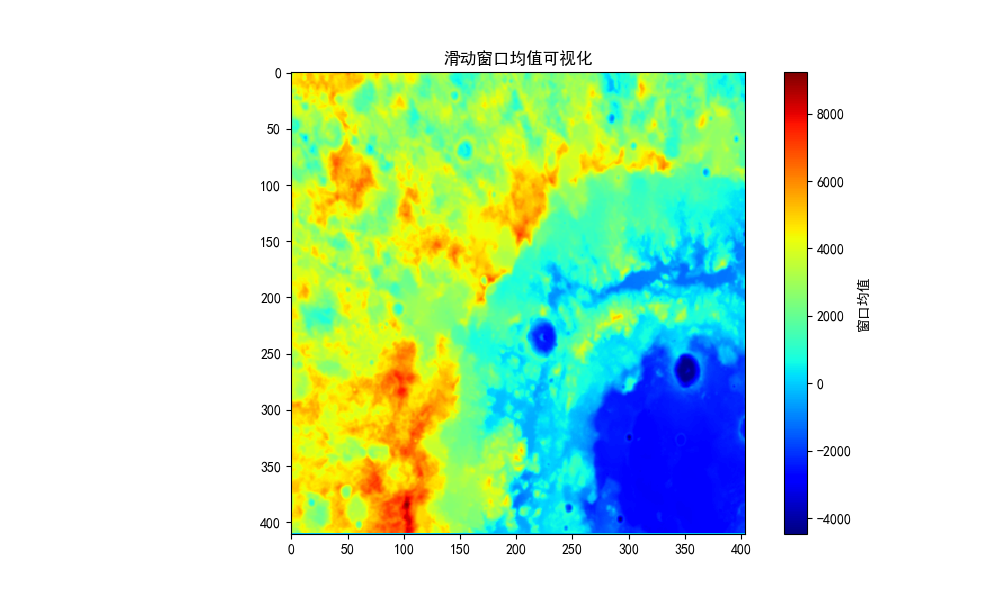

In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from osgeo import gdal
from langchain.tools import Tool
from langchain.agents import initialize_agent
from langchain.chat_models import ChatOpenAI
from IPython.display import display, HTML, Image
import re

# ** 设置 Matplotlib 支持中文字符 **
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号问题

# **1️⃣ 读取 TIFF 文件并进行属性判断**
def check_tiff_properties(input_tiff_path):
    dataset = gdal.Open(input_tiff_path)
    if dataset is None:
        return "❌ 无法打开 TIFF 文件"

    # 获取 TIFF 图像的基本信息
    rows = dataset.RasterYSize  # 行数
    cols = dataset.RasterXSize  # 列数
    band = dataset.GetRasterBand(1)

    # 输出 TIFF 的基本信息
    print(f"TIFF 图像大小：{rows} 行 x {cols} 列")
    
    return dataset, rows, cols, band

# **2️⃣ 滑动窗口处理（计算窗口内均值）**
# **2️⃣ 滑动窗口处理（计算窗口内均值）**
def sliding_window_mean(input_tiff_path, output_folder="D:/Mars/process2", window_factor=50):
    # 读取 TIFF 文件属性
    dataset, rows, cols, band = check_tiff_properties(input_tiff_path)
    if isinstance(dataset, str):  # 错误信息
        return dataset

    # 创建输出文件夹
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # 计算窗口大小（横向与纵向除以 window_factor）
    window_height = rows // window_factor
    window_width = cols // window_factor

    # 纵向步长是窗口高的一半，横向步长是窗口宽的一半
    stride_vertical = window_height // 2
    stride_horizontal = window_width // 2

    print(f"滑动窗口大小：{window_width} x {window_height}")
    print(f"纵向步长：{stride_vertical}, 横向步长：{stride_horizontal}")
    
    # 读取 TIFF 数据
    tiff_data = band.ReadAsArray(0, 0, cols, rows).astype(np.float32)

    # 滑动窗口处理，计算窗口均值
    mean_values = np.zeros((rows // stride_vertical, cols // stride_horizontal), dtype=np.float32)
    
    for i, row in enumerate(range(0, rows - window_height, stride_vertical)):  # 滑动窗口的纵向方向
        for j, col in enumerate(range(0, cols - window_width, stride_horizontal)):  # 滑动窗口的横向方向
            window_data = tiff_data[row:row + window_height, col:col + window_width]
            mean_values[i, j] = np.nanmean(window_data)  # 计算窗口均值
    
    # ** 保存均值数据到 CSV ** 
    csv_path = os.path.join(output_folder, "sliding_window_mean.csv")
    pd.DataFrame(mean_values).to_csv(csv_path, index=False, header=False)

    # ** 可视化窗口均值 **
    output_image = os.path.join(output_folder, "sliding_window_mean.png")
    plt.figure(figsize=(10, 6))
    plt.imshow(mean_values, cmap="jet", interpolation="nearest")
    plt.colorbar(label="窗口均值")
    plt.title("滑动窗口均值可视化")
    plt.savefig(output_image)
    plt.close()

    total_windows = mean_values.shape[0] * mean_values.shape[1]  # 计算窗口总数

    return f"✅ 滑动窗口均值计算完成，共处理 {total_windows} 个窗口，CSV 保存于：{csv_path}，图像保存于：{output_image}"

# **3️⃣ 初始化 LangChain 大模型**
llm = ChatOpenAI(
    openai_api_key="sk-9d937bf4eeed4cc5b90380549e2f8d08",  # 替换为你的 OpenAI API Key
    openai_api_base="https://dashscope.aliyuncs.com/compatible-mode/v1",
    model_name="qwen-max",
    max_tokens=300,
    temperature=0,
    streaming=False
)

# **4️⃣ 定义 LangChain Agent 可调用的工具**
sliding_window_tool_obj = Tool(
    name="Sliding_Window_Mean",
    func=lambda x: sliding_window_mean(
        x.split(", ")[0],  # TIFF 文件路径
        x.split(", ")[1] if len(x.split(", ")) > 1 else "D:/Mars/process2",  # 输出文件夹
        int(x.split(", ")[2]) if len(x.split(", ")) > 2 else 100  # 窗口因子（默认100）
    ),
    description="对 TIFF 影像进行滑动窗口均值计算并生成可视化，格式：<TIFF路径>, <输出文件夹>, <窗口因子>"
)

# **5️⃣ 初始化 LangChain Agent**
agent = initialize_agent(
    tools=[sliding_window_tool_obj],
    llm=llm,
    agent="zero-shot-react-description",
    verbose=True,
    allow_dangerous_code=True
)

# **6️⃣ 执行部分**
tiff_path = r"D:\Mars\LunarDEMBlock\LunarDEMBlock.tif"
output_folder = r"D:\Mars\process2"

# **使用 LangChain Agent 运行滑动窗口均值计算**
response = agent.run(f"{tiff_path}, {output_folder}, 200")
print(response)

# **7️⃣ 在 Jupyter Notebook 中显示生成的 CSV 和图像**
csv_path = os.path.join(output_folder, "sliding_window_mean.csv")
output_image = os.path.join(output_folder, "sliding_window_mean.png")

display(HTML(f"✅ 滑动窗口均值可视化已生成：{output_image}"))
display(Image(filename=output_image))  # 直接显示图像



> Entering new AgentExecutor chain...
看起来用户想要对位于 `D:\Mars\LunarDEMBlock\LunarDEMBlock.tif` 的 TIFF 影像文件执行某种处理，并且提到了输出路径为 `D:\Mars\process3\average_tool` 以及参数5。根据提供的工具列表，提到的“5”可能是指卷积核或池化窗口的大小。由于提到了“average”，这暗示着可能是想使用平均值相关的处理方法，因此这里更适合采用`Convolution_Mean`函数来完成任务。
Action: Convolution_Mean
Action Input: D:\Mars\LunarDEMBlock\LunarDEMBlock.tif, D:\Mars\process3\average_tool, 5TIFF 图像大小：5760 行 x 7680 列

Observation: ✅ 卷积处理完成，CSV 保存于：D:\Mars\process3\average_tool\convolution_mean.csv，图像保存于：D:\Mars\process3\average_tool\convolution_mean.png
Thought:I now know the final answer
Final Answer: 对 `D:\Mars\LunarDEMBlock\LunarDEMBlock.tif` 的 TIFF 影像文件使用大小为 5 的卷积核进行了平均值卷积处理。处理结果已保存，其中 CSV 文件位于 `D:\Mars\process3\average_tool\convolution_mean.csv`，可视化图像位于 `D:\Mars\process3\average_tool\convolution_mean.png`。

> Finished chain.
对 `D:\Mars\LunarDEMBlock\LunarDEMBlock.tif` 的 TIFF 影像文件使用大小为 5 的卷积核进行了平均值卷积处理。处理结果已保存，其中 CSV 文件位于 `D:\Mars\process3\average_tool\convolution_mean.csv`，可视化图像位于 `D:\Mars\process3\

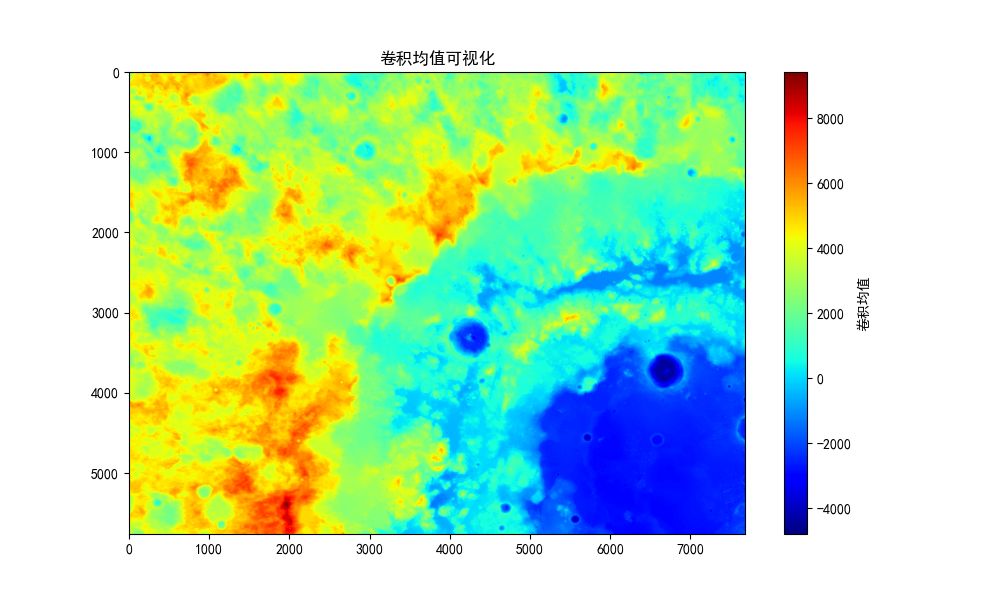

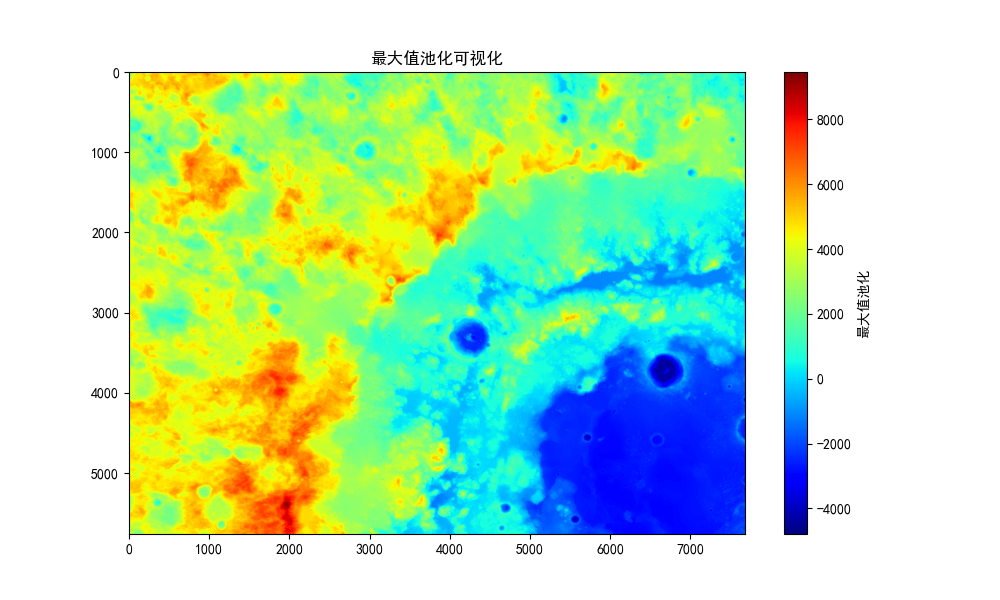

In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from osgeo import gdal
from scipy.ndimage import convolve, maximum_filter
from langchain.tools import Tool
from langchain.agents import initialize_agent
from langchain.chat_models import ChatOpenAI
from IPython.display import display, HTML, Image
import re

# ** 设置 Matplotlib 支持中文字符 **
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号问题

# **1️⃣ 读取 TIFF 文件并进行属性判断**
def check_tiff_properties(input_tiff_path):
    dataset = gdal.Open(input_tiff_path)
    if dataset is None:
        return "❌ 无法打开 TIFF 文件"

    # 获取 TIFF 图像的基本信息
    rows = dataset.RasterYSize  # 行数
    cols = dataset.RasterXSize  # 列数
    band = dataset.GetRasterBand(1)

    # 输出 TIFF 的基本信息
    print(f"TIFF 图像大小：{rows} 行 x {cols} 列")
    
    return dataset, rows, cols, band

# **2️⃣ 使用卷积核进行图像处理（5x5均值滤波）**
def convolution_mean(input_tiff_path, output_folder="D:/Mars/process2", kernel_size=5):
    # 读取 TIFF 文件属性
    dataset, rows, cols, band = check_tiff_properties(input_tiff_path)
    if isinstance(dataset, str):  # 错误信息
        return dataset

    # 创建输出文件夹
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # 读取 TIFF 数据
    tiff_data = band.ReadAsArray(0, 0, cols, rows).astype(np.float32)

    # **3️⃣ 创建卷积核（均值滤波器）**
    kernel = np.ones((kernel_size, kernel_size), dtype=np.float32) / (kernel_size ** 2)

    # **4️⃣ 使用卷积进行图像处理**
    smoothed_data = convolve(tiff_data, kernel, mode='nearest')

    # ** 保存卷积结果到 CSV ** 
    csv_path = os.path.join(output_folder, "convolution_mean.csv")
    pd.DataFrame(smoothed_data).to_csv(csv_path, index=False, header=False)

    # ** 可视化卷积结果 **
    output_image = os.path.join(output_folder, "convolution_mean.png")
    plt.figure(figsize=(10, 6))
    plt.imshow(smoothed_data, cmap="jet", interpolation="nearest")
    plt.colorbar(label="卷积均值")
    plt.title("卷积均值可视化")
    plt.savefig(output_image)
    plt.close()

    return f"✅ 卷积处理完成，CSV 保存于：{csv_path}，图像保存于：{output_image}"

# **3️⃣ 使用最大值池化（Max Pooling）**
def max_pooling(input_tiff_path, output_folder="D:/Mars/process2", pool_size=2):
    # 读取 TIFF 文件属性
    dataset, rows, cols, band = check_tiff_properties(input_tiff_path)
    if isinstance(dataset, str):  # 错误信息
        return dataset

    # 创建输出文件夹
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # 读取 TIFF 数据
    tiff_data = band.ReadAsArray(0, 0, cols, rows).astype(np.float32)

    # **4️⃣ 使用最大值池化进行图像处理**
    pooled_data = maximum_filter(tiff_data, size=pool_size, mode='nearest')

    # ** 保存池化结果到 CSV ** 
    csv_path = os.path.join(output_folder, "max_pooling.csv")
    pd.DataFrame(pooled_data).to_csv(csv_path, index=False, header=False)

    # ** 可视化池化结果 **
    output_image = os.path.join(output_folder, "max_pooling.png")
    plt.figure(figsize=(10, 6))
    plt.imshow(pooled_data, cmap="jet", interpolation="nearest")
    plt.colorbar(label="最大值池化")
    plt.title("最大值池化可视化")
    plt.savefig(output_image)
    plt.close()

    return f"✅ 最大值池化处理完成，CSV 保存于：{csv_path}，图像保存于：{output_image}"

# **4️⃣ 初始化 LangChain 大模型**
llm = ChatOpenAI(
    openai_api_key="sk-9d937bf4eeed4cc5b90380549e2f8d08",  # 替换为你的 OpenAI API Key
    openai_api_base="https://dashscope.aliyuncs.com/compatible-mode/v1",
    model_name="qwen-max",
    max_tokens=300,
    temperature=0,
    streaming=False
)

# **5️⃣ 定义 LangChain Agent 可调用的工具**
convolution_tool_obj = Tool(
    name="Convolution_Mean",
    func=lambda x: convolution_mean(
        x.split(", ")[0],  # TIFF 文件路径
        x.split(", ")[1] if len(x.split(", ")) > 1 else "D:/Mars/process2",  # 输出文件夹
        int(x.split(", ")[2]) if len(x.split(", ")) > 2 else 5  # 卷积核大小（默认5x5）
    ),
    description="对 TIFF 影像进行卷积处理并生成可视化，格式：<TIFF路径>, <输出文件夹>, <卷积核大小>"
)

max_pooling_tool_obj = Tool(
    name="Max_Pooling",
    func=lambda x: max_pooling(
        x.split(", ")[0],  # TIFF 文件路径
        x.split(", ")[1] if len(x.split(", ")) > 1 else "D:/Mars/process2",  # 输出文件夹
        int(x.split(", ")[2]) if len(x.split(", ")) > 2 else 2  # 池化大小（默认2x2）
    ),
    description="对 TIFF 影像进行最大值池化处理并生成可视化，格式：<TIFF路径>, <输出文件夹>, <池化大小>"
)

# **6️⃣ 初始化 LangChain Agent**
agent = initialize_agent(
    tools=[convolution_tool_obj, max_pooling_tool_obj],
    llm=llm,
    agent="zero-shot-react-description",
    verbose=True,
    allow_dangerous_code=True
)

# **7️⃣ 执行卷积均值计算与最大值池化操作**
tiff_path = r"D:\Mars\LunarDEMBlock\LunarDEMBlock.tif"
output_folder1 = r"D:\Mars\process3\max_tool"
output_folder2 = r"D:\Mars\process3\average_tool"

# **使用 LangChain Agent 运行卷积均值计算**
response_convolution = agent.run(f"{tiff_path}, {output_folder2}, 5")
print(response_convolution)

# **使用 LangChain Agent 运行最大值池化**
response_max_pooling = agent.run(f"{tiff_path}, {output_folder1}, 5")
print(response_max_pooling)

# **9️⃣ 在 Jupyter Notebook 中显示生成的 CSV 和图像**
csv_path_convolution = os.path.join(output_folder2, "convolution_mean.csv")
output_image_convolution = os.path.join(output_folder2, "convolution_mean.png")

csv_path_max_pooling = os.path.join(output_folder1, "max_pooling.csv")
output_image_max_pooling = os.path.join(output_folder1, "max_pooling.png")

# 使用正则表达式提取相关信息
match_convolution = re.search(r'CSV 保存于：(.*)，图像保存于：(.*)', response_convolution)
if match_convolution:
    csv_path_convolution = match_convolution.group(1)
    output_image_convolution = match_convolution.group(2)

match_max_pooling = re.search(r'CSV 保存于：(.*)，图像保存于：(.*)', response_max_pooling)
if match_max_pooling:
    csv_path_max_pooling = match_max_pooling.group(1)
    output_image_max_pooling = match_max_pooling.group(2)

# 显示结果
display(HTML(f"✅ 处理完成，卷积均值 CSV 文件保存于：{csv_path_convolution}"))
display(HTML(f"✅ 卷积均值可视化已生成：{output_image_convolution}"))
display(HTML(f"✅ 最大值池化 CSV 文件保存于：{csv_path_max_pooling}"))
display(HTML(f"✅ 最大值池化可视化已生成：{output_image_max_pooling}"))

display(Image(filename=output_image_convolution))  # 显示卷积均值图像
display(Image(filename=output_image_max_pooling))  # 显示最大值池化图像

C:\Users\wyb04\AppData\Local\Temp\ipykernel_31780\3748352699.py:69: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(
C:\Users\wyb04\AppData\Local\Temp\ipykernel_31780\3748352699.py:90: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/



> Entering new AgentExecutor chain...
我需要使用Convolution_Mean工具对提供的TIFF影像文件进行卷积处理，根据指定的参数生成可视化结果。这些参数包括TIFF文件路径、输出文件夹以及卷积核大小。
Action: Convolution_Mean
Action Input: D:\Mars\LunarDEMBlock\LunarDEMBlock.tif, D:\Mars\process3\average_tool, 50TIFF 图像大小：5760 行 x 7680 列


d:\ProgramData\Anaconda3\envs\task1\lib\site-packages\osgeo\gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(



Observation: ✅ 卷积处理完成，CSV 保存于：D:\Mars\process3\average_tool\convolution_mean.csv，图像保存于：D:\Mars\process3\average_tool\convolution_mean.png
Thought:我通过使用Convolution_Mean工具成功完成了对指定TIFF影像文件的卷积处理，并根据给定的卷积核大小生成了可视化结果。输出包括一个CSV文件，记录了处理后的数据，以及一张PNG格式的图像，直观展示了处理结果。
Final Answer: 对D:\Mars\LunarDEMBlock\LunarDEMBlock.tif文件使用50大小的卷积核进行了卷积处理，处理结果已保存至D:\Mars\process3\average_tool目录下，其中包括名为convolution_mean.csv的数据文件和名为convolution_mean.png的可视化图像。

> Finished chain.
对D:\Mars\LunarDEMBlock\LunarDEMBlock.tif文件使用50大小的卷积核进行了卷积处理，处理结果已保存至D:\Mars\process3\average_tool目录下，其中包括名为convolution_mean.csv的数据文件和名为convolution_mean.png的可视化图像。


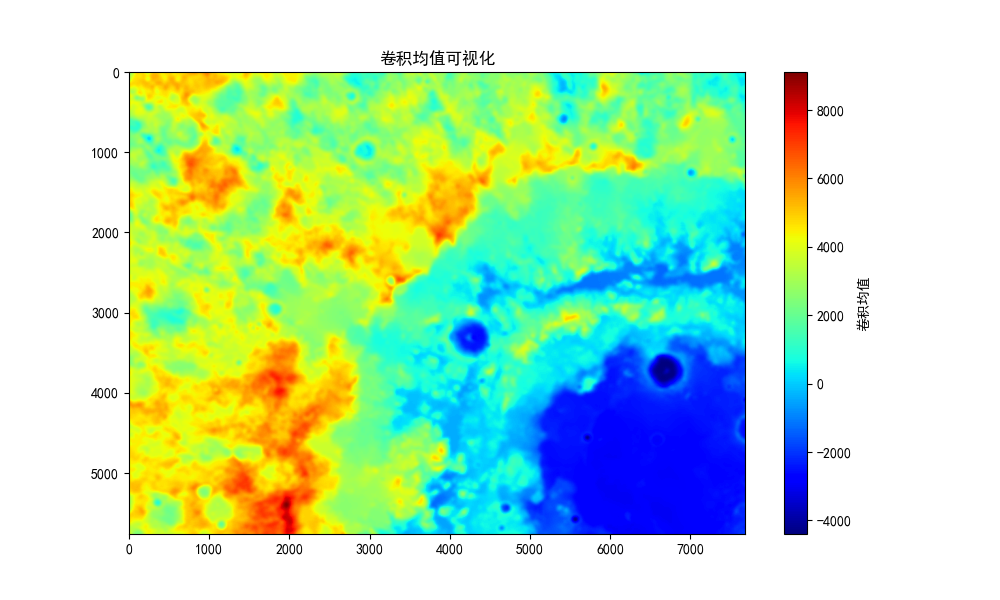

: 

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from osgeo import gdal
from scipy.ndimage import convolve
from langchain.tools import Tool
from langchain.agents import initialize_agent
from langchain.chat_models import ChatOpenAI
from IPython.display import display, HTML, Image
import re

# ** 设置 Matplotlib 支持中文字符 **
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号问题

# **1️⃣ 读取 TIFF 文件并进行属性判断**
def check_tiff_properties(input_tiff_path):
    dataset = gdal.Open(input_tiff_path)
    if dataset is None:
        return "❌ 无法打开 TIFF 文件"

    # 获取 TIFF 图像的基本信息
    rows = dataset.RasterYSize  # 行数
    cols = dataset.RasterXSize  # 列数
    band = dataset.GetRasterBand(1)

    # 输出 TIFF 的基本信息
    print(f"TIFF 图像大小：{rows} 行 x {cols} 列")
    
    return dataset, rows, cols, band

# **2️⃣ 使用卷积核进行图像处理（5x5均值滤波）**
def convolution_mean(input_tiff_path, output_folder="D:/Mars/process2", kernel_size=5):
    # 读取 TIFF 文件属性
    dataset, rows, cols, band = check_tiff_properties(input_tiff_path)
    if isinstance(dataset, str):  # 错误信息
        return dataset

    # 创建输出文件夹
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # 读取 TIFF 数据
    tiff_data = band.ReadAsArray(0, 0, cols, rows).astype(np.float32)

    # **3️⃣ 创建卷积核（均值滤波器）**
    kernel = np.ones((kernel_size, kernel_size), dtype=np.float32) / (kernel_size ** 2)

    # **4️⃣ 使用卷积进行图像处理**
    smoothed_data = convolve(tiff_data, kernel, mode='nearest')

    # ** 保存卷积结果到 CSV ** 
    csv_path = os.path.join(output_folder, "convolution_mean.csv")
    pd.DataFrame(smoothed_data).to_csv(csv_path, index=False, header=False)

    # ** 可视化卷积结果 **
    output_image = os.path.join(output_folder, "convolution_mean.png")
    plt.figure(figsize=(10, 6))
    plt.imshow(smoothed_data, cmap="jet", interpolation="nearest")
    plt.colorbar(label="卷积均值")
    plt.title("卷积均值可视化")
    plt.savefig(output_image)
    plt.close()

    return f"✅ 卷积处理完成，CSV 保存于：{csv_path}，图像保存于：{output_image}"

# **5️⃣ 初始化 LangChain 大模型**
llm = ChatOpenAI(
    openai_api_key="sk-9d937bf4eeed4cc5b90380549e2f8d08",  # 替换为你的 OpenAI API Key
    openai_api_base="https://dashscope.aliyuncs.com/compatible-mode/v1",
    model_name="qwen-max",
    max_tokens=300,
    temperature=0,
    streaming=False
)

# **6️⃣ 定义 LangChain Agent 可调用的工具**
convolution_tool_obj = Tool(
    name="Convolution_Mean",
    func=lambda x: convolution_mean(
        x.split(", ")[0],  # TIFF 文件路径
        x.split(", ")[1] if len(x.split(", ")) > 1 else "D:/Mars/process2",  # 输出文件夹
        int(x.split(", ")[2]) if len(x.split(", ")) > 2 else 5  # 卷积核大小（默认5x5）
    ),
    description="对 TIFF 影像进行卷积处理并生成可视化，格式：<TIFF路径>, <输出文件夹>, <卷积核大小>"
)

# **7️⃣ 初始化 LangChain Agent**
agent = initialize_agent(
    tools=[convolution_tool_obj],
    llm=llm,
    agent="zero-shot-react-description",
    verbose=True,
    allow_dangerous_code=True
)

# **8️⃣ 执行部分**
tiff_path = r"D:\Mars\LunarDEMBlock\LunarDEMBlock.tif"
output_folder = r"D:\Mars\process3\average_tool"

# **使用 LangChain Agent 运行卷积均值计算**
response = agent.run(f"{tiff_path}, {output_folder}, 50")
print(response)

# **9️⃣ 在 Jupyter Notebook 中显示生成的 CSV 和图像**
csv_path = os.path.join(output_folder, "convolution_mean.csv")
output_image = os.path.join(output_folder, "convolution_mean.png")

# 使用正则表达式提取相关信息
match = re.search(r'CSV 保存于：(.*)，图像保存于：(.*)', response)
if match:
    csv_path = match.group(1)
    output_image = match.group(2)

# 显示结果
display(HTML(f"✅ 处理完成，CSV 文件保存于：{csv_path}"))
display(HTML(f"✅ 卷积均值可视化已生成：{output_image}"))
display(Image(filename=output_image))  # 直接显示图像